#### Copyright (C) 2022 Sobhan Moradian Daghigh
#### Date: 2/10/2022

### Import Libraries

In [4]:
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

from IPython.display import display

import import_ipynb, importlib, sys
import feature_selection_methods as FS
import classifier_models as models
def reload_moduls():
    importlib.reload(sys.modules['feature_selection_methods'])
    importlib.reload(sys.modules['classifier_models'])
    import feature_selection_methods as FS
    import classifier_models as models
    
    return FS, models

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

[nltk_data] Downloading package stopwords to C:\Users\Virgil Van
[nltk_data]     Dijk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Virgil Van
[nltk_data]     Dijk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading Datasets

In [17]:
def load_datasets(path):
    datasets = []
    print('Loading the datasets..\n')
    for _, dirs, files in os.walk(path):
        for i, direc in enumerate(dirs):
            train_test = []
            for root, _, files in os.walk(path + direc):
                print(' |_  {}. {} loaded'.format(i + 1, direc))
                for file in files:
                    data = pd.read_csv(os.path.join(root, file), names=['sentence'], sep='\t')
                    train_test.append(data)
            datasets.append(train_test)
    return datasets

In [18]:
datasets_name = ['Books      ', 'DVD        ', 'Electronics', 'Kitchen    ']
datasets = load_datasets('./Datasets/BDEK/')

Loading the datasets..

 |_  1. Books loaded
 |_  2. DVD loaded
 |_  3. Electronics loaded
 |_  4. Kitchen loaded


In [27]:
# Books
datasets[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1600 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


In [28]:
# DVD
datasets[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1600 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


In [29]:
# Electronics
datasets[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1600 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


In [32]:
# Kitchen
datasets[3][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1600 non-null   object
dtypes: object(1)
memory usage: 12.6+ KB


### Make a preprocess on the comments to improve quality and remove unneccessary words
##### 1. convert all words to lowercase
##### 2. remove punctuations
##### 3. tonekize words
##### 4. remove stopwords
##### 5. use porterStemmer to have stemming words

In [33]:
def nlprocess(dataset):
    preprocessed_comments = []
    for _, text in dataset.iterrows():

        text = text[0]
        #Lowercase
        text = text.lower()

        # Removing Punctuation
        text = "".join([char for char in text if char not in string.punctuation])

        # Word Tokenization
        text = word_tokenize(text)

        # Stopword Filtering
        stop_words = stopwords.words('english')
        text = [word for word in text if word not in stop_words]

        # Stemming
        porter = PorterStemmer()
        text = [porter.stem(word) for word in text]

        text = ' '.join(text)

        preprocessed_comments.append(text)

    return preprocessed_comments

### Splitting the datasets into Train and Test

In [36]:
def spliter(datasets):
    x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = [], [], [], []
    print('(train, test):')
    for i, dataset in enumerate(datasets):
        x_train, x_test = dataset[1], dataset[0]
        tr, ts = np.zeros(len(x_train)), np.zeros(len(x_test))
        tr[:len(x_train) // 2], ts[:len(x_test) // 2] = 1, 1
        y_train, y_test = tr, ts

        x_train_datasets.append(nlprocess(x_train))
        x_test_datasets.append(nlprocess(x_test))
        y_train_datasets.append(y_train)
        y_test_datasets.append(y_test)
        print(' |_ {}: ({}, {})'.format(datasets_name[i], len(x_train), len(x_test)))
    return x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets

In [37]:
x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = spliter(datasets)

(train, test):
 |_ Books      : (1600, 400)
 |_ DVD        : (1600, 400)
 |_ Electronics: (1600, 400)
 |_ Kitchen    : (1600, 400)


### Feature Extraction using TF-IDF

In [38]:
def feature_extractor(dataset):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(dataset)
    return vectorizer

In [39]:
def get_top_frequent_features(vectorizer):
    df = pd.DataFrame({'words': vectorizer.vocabulary_.keys(), 'counts': vectorizer.vocabulary_.values()})
    print('\n------ {} ------'.format(datasets_name[i]))
    display(df.sort_values(by=['counts'], ascending=False).head())

#### Top 5 frequent words of each dataset to get a full feeling of the problem

In [40]:
def wordcloud(data):
    mask = np.array(Image.open('./panda.jpg'))
    wordcloud = WordCloud(
        mask=mask,
        background_color='white',
        max_words=1000,
        max_font_size=60,
        scale=3,
        random_state=1
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()


------ Books       ------


,words,counts
16900,zylpha,17639
14070,zukav,17638
7233,zucker,17637
15616,zoroastrian,17636
16209,zoom,17635


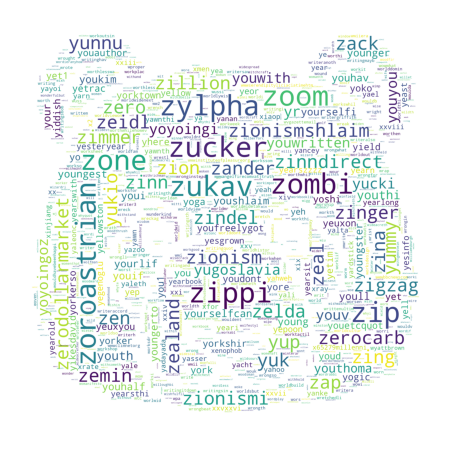


------ DVD         ------


,words,counts
15350,zukav,18530
5107,zoot,18529
11944,zoomat,18528
17212,zoo,18527
1305,zone,18526


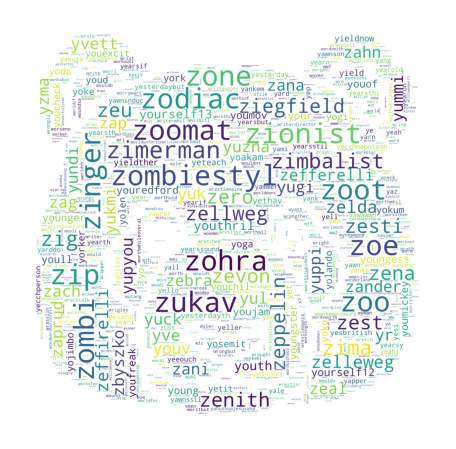


------ Electronics ------


,words,counts
7798,zz,10160
5184,zune,10159
6349,zs,10158
9047,zr90,10157
453,zoom,10156


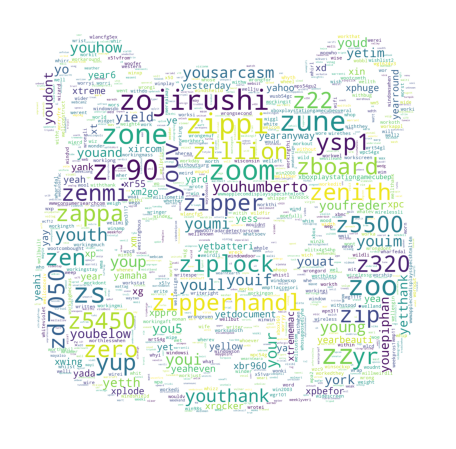


------ Kitchen     ------


,words,counts
3372,zyliss,7939
2941,zucchini,7938
6954,zone,7937
3982,zojirushi,7936
7822,zipperr,7935


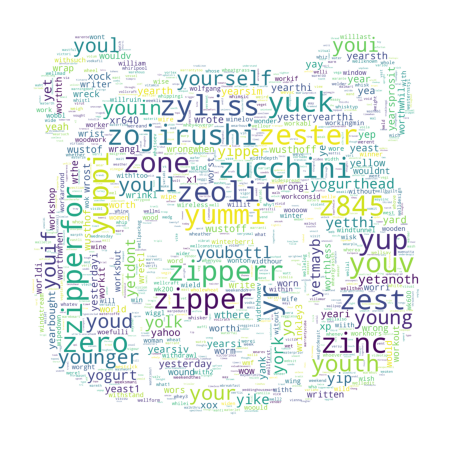

In [41]:
# Display
vectorizers = []
for i, dataset in enumerate(x_train_datasets):
    vectorizer = feature_extractor(dataset)
    get_top_frequent_features(vectorizer)
    wordcloud(vectorizer.vocabulary_)   
    vectorizers.append(vectorizer)

### Logistic Regression
#### - Without FS

In [42]:
print("Accuracy:")
clfs = []
vectorized_trains = []
vectorized_tests = []

for i, (vec, x_tr, x_ts, y_tr, y_ts) in enumerate(zip(vectorizers, x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets)):
    X_train = vec.transform(x_tr)
    X_test = vec.transform(x_ts)

    vectorized_trains.append(X_train)
    vectorized_tests.append(X_test)
    
    clf = LogisticRegression()
    clf.fit(X_train, y_tr)
    clfs.append(clf)
    score = clf.score(X_test, y_ts)
    
    print(' |_  {}: {:.2f}'.format(datasets_name[i], score))

Accuracy:
 |_  Books      : 0.78
 |_  DVD        : 0.81
 |_  Electronics: 0.81
 |_  Kitchen    : 0.81


### Apply the selected features to datasets

In [43]:
def apply_selected_features(datasets, tops):
    filter_datasets = []
    for dataset, top in zip(datasets, tops):
        filter_dataset = np.array(np.take(dataset.todense(), top, axis=1))
        filter_datasets.append(filter_dataset)
    return filter_datasets

### Display the top features

In [44]:
def display_tops(tops, vectorizers):
    for i, (top, vec) in enumerate(zip(tops, vectorizers)):
        name = np.array(vec.get_feature_names_out())[top].tolist()
        print('\n{}:'.format(datasets_name[i]))
        display(pd.DataFrame(name).head())

In [45]:
# Including the features which are selected by different FS methods
fs_tops = []
fs_methods_name = ['Odd-Ratio', 'Chi-Square', 'Count-Difference']

### 1. Odd Ratio FS

In [55]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

odd_ratio_tops = FS.odd_ratio(clfs, datasets_name=datasets_name)
fs_tops.append(odd_ratio_tops)
display_tops(odd_ratio_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Books      : (17640, 8819)
 |_ DVD        : (18531, 9914)
 |_ Electronics: (10161, 5325)
 |_ Kitchen    : (7940, 4039)

Books      :


,0
0,recommend
1,love
2,great
3,excel
4,easi



DVD        :


,0
0,great
1,love
2,best
3,enjoy
4,wonder



Electronics:


,0
0,great
1,price
2,use
3,excel
4,best



Kitchen    :


,0
0,easi
1,love
2,great
3,nice
4,perfect


### 2. Chi-Square FS

In [56]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

chi_tops = FS.chi_square(vectorized_trains, y_train_datasets, datasets_name=datasets_name)
fs_tops.append(chi_tops)
display_tops(chi_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Books      : (17640, 264)
 |_ DVD        : (18531, 284)
 |_ Electronics: (10161, 352)
 |_ Kitchen    : (7940, 372)

Books      :


,0
0,bore
1,wast
2,bad
3,highli
4,easi



DVD        :


,0
0,wast
1,worst
2,great
3,bore
4,horribl



Electronics:


,0
0,return
1,great
2,price
3,wast
4,excel



Kitchen    :


,0
0,easi
1,return
2,love
3,great
4,disappoint


### 3. Count Difference FS

In [57]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

cd_tops = FS.count_diff(vectorized_trains, y_train_datasets, datasets_name=datasets_name)
fs_tops.append(cd_tops)
display_tops(cd_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Books      : (17640, 794)
 |_ DVD        : (18531, 774)
 |_ Electronics: (10161, 763)
 |_ Kitchen    : (7940, 807)

Books      :


,0
0,bore
1,recommend
2,dont
3,wast
4,bad



DVD        :


,0
0,great
1,love
2,wast
3,bad
4,bore



Electronics:


,0
0,great
1,return
2,price
3,use
4,good



Kitchen    :


,0
0,easi
1,love
2,great
3,return
4,clean


### 4. GSS FS

In [58]:
# Reload the sub_modules to apply changes
# FS, models = reload_moduls()

# gss_tops = FS.gss(vectorizers, y_train_datasets, datasets_name=datasets_name)
# fs_tops.append(gss_tops)
# display_tops(gss_tops, vectorizers)

### ------------------------------------------------------------    Models    ---------------------------------------------------

### Logistic Regression

In [60]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.logestic_regression(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.72 - 0.71
 |_  DVD        : 0.69 - 0.68
 |_  Electronics: 0.73 - 0.73
 |_  Kitchen    : 0.77 - 0.76

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.77 - 0.79
 |_  DVD        : 0.80 - 0.81
 |_  Electronics: 0.83 - 0.83
 |_  Kitchen    : 0.81 - 0.81

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.78 - 0.79
 |_  DVD        : 0.80 - 0.80
 |_  Electronics: 0.81 - 0.81
 |_  Kitchen    : 0.82 - 0.82


### Linear SVM

In [62]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.linear_svm(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.72 - 0.72
 |_  DVD        : 0.70 - 0.68
 |_  Electronics: 0.75 - 0.75
 |_  Kitchen    : 0.77 - 0.75

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.81 - 0.81
 |_  Electronics: 0.84 - 0.84
 |_  Kitchen    : 0.81 - 0.81

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.76 - 0.77
 |_  DVD        : 0.81 - 0.80
 |_  Electronics: 0.81 - 0.81
 |_  Kitchen    : 0.82 - 0.82


### RBF SVM

In [63]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.rbf_svm(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.69 - 0.69
 |_  DVD        : 0.70 - 0.72
 |_  Electronics: 0.76 - 0.75
 |_  Kitchen    : 0.73 - 0.73

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.80 - 0.81
 |_  Electronics: 0.84 - 0.85
 |_  Kitchen    : 0.82 - 0.81

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.77 - 0.78
 |_  DVD        : 0.79 - 0.79
 |_  Electronics: 0.81 - 0.81
 |_  Kitchen    : 0.82 - 0.81


### Decision Tree

In [64]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.decision_tree(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.64 - 0.55
 |_  DVD        : 0.63 - 0.59
 |_  Electronics: 0.70 - 0.67
 |_  Kitchen    : 0.68 - 0.61

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.62 - 0.68
 |_  DVD        : 0.64 - 0.69
 |_  Electronics: 0.69 - 0.63
 |_  Kitchen    : 0.71 - 0.68

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.61 - 0.67
 |_  DVD        : 0.62 - 0.69
 |_  Electronics: 0.71 - 0.68
 |_  Kitchen    : 0.70 - 0.67


### MNB

In [65]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.multinomial_naive_bayes(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.64 - 0.70
 |_  DVD        : 0.61 - 0.70
 |_  Electronics: 0.63 - 0.68
 |_  Kitchen    : 0.71 - 0.74

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.77
 |_  DVD        : 0.79 - 0.80
 |_  Electronics: 0.80 - 0.80
 |_  Kitchen    : 0.80 - 0.80

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.81 - 0.81
 |_  Electronics: 0.79 - 0.79
 |_  Kitchen    : 0.79 - 0.79


### BNB

In [66]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.bernoulli_naive_bayes(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.52 - 0.26
 |_  DVD        : 0.59 - 0.39
 |_  Electronics: 0.57 - 0.35
 |_  Kitchen    : 0.60 - 0.45

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.74 - 0.78
 |_  DVD        : 0.80 - 0.81
 |_  Electronics: 0.81 - 0.82
 |_  Kitchen    : 0.80 - 0.80

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.82 - 0.82
 |_  Electronics: 0.78 - 0.79
 |_  Kitchen    : 0.83 - 0.83


### Bagging Ensemble

In [67]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()
classifiers = ['LR', 'SVM-Linear', 'SVM-RBF', 'DT', 'MNB', 'BNB']
print('Bagging Ensemble Classifiers with')

for j, classifier in enumerate(classifiers):
    print('\n----- {} -----'.format(classifiers[j]))
    for i, tops in enumerate(fs_tops):
        print('\nFS: {}'.format(fs_methods_name[i]))
        filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
        filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
        models.bagging(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, classifiers[j], datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
Bagging Ensemble Classifiers with

----- LR -----

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.71 - 0.68
 |_  DVD        : 0.68 - 0.64
 |_  Electronics: 0.74 - 0.73
 |_  Kitchen    : 0.76 - 0.73

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.80 - 0.80
 |_  Electronics: 0.83 - 0.84
 |_  Kitchen    : 0.81 - 0.81

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.79 - 0.80
 |_  DVD        : 0.79 - 0.79
 |_  Electronics: 0.80 - 0.80
 |_  Kitchen    : 0.82 - 0.81

----- SVM-Linear -----

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.70 - 0.66
 |_  DVD        : 0.70 - 0.65
 |_  Electronics: 0.73 - 0.70
 |_  Kitchen    : 0.75 - 0.72

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.80 - 0.80
 |_  Electronics: 0.84 - 0.84
 |_  Kitchen    : 0.81 - 0.81

F

###  Random Subspace Ensemble

In [68]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()
classifiers = ['LR', 'SVM-Linear', 'SVM-RBF', 'DT', 'MNB', 'BNB']
print('Random Subspace Ensemble Classifiers with')

for j, classifier in enumerate(classifiers):
    print('\n----- {} -----'.format(classifiers[j]))
    for i, tops in enumerate(fs_tops):
        print('\nFS: {}'.format(fs_methods_name[i]))
        filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
        filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
        models.ens_voting(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets, classifiers[j], datasets_name=datasets_name)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
Random Subspace Ensemble Classifiers with

----- LR -----

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.72 - 0.72
 |_  DVD        : 0.69 - 0.68
 |_  Electronics: 0.74 - 0.73
 |_  Kitchen    : 0.78 - 0.77

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.80 - 0.80
 |_  Electronics: 0.83 - 0.83
 |_  Kitchen    : 0.81 - 0.81

FS: Count-Difference
             acc  -  f1
 |_  Books      : 0.77 - 0.78
 |_  DVD        : 0.80 - 0.80
 |_  Electronics: 0.81 - 0.81
 |_  Kitchen    : 0.82 - 0.81

----- SVM-Linear -----

FS: Odd-Ratio
             acc  -  f1
 |_  Books      : 0.73 - 0.73
 |_  DVD        : 0.70 - 0.68
 |_  Electronics: 0.76 - 0.76
 |_  Kitchen    : 0.77 - 0.75

FS: Chi-Square
             acc  -  f1
 |_  Books      : 0.76 - 0.78
 |_  DVD        : 0.80 - 0.81
 |_  Electronics: 0.84 - 0.85
 |_  Kitchen    : 0.81 -